# ⛳ 트랜스포머로 만드는 대화형 챗봇 ⛳

### 대화형 챗봇이란❓❓❓

인공지능이라고 할 때 처음 떠오르는 것은 인간의 언어를 이해하고 인간과 자연어로 대화할 수 있는 기계를 떠올릴 것이다.

이미 시리나 구글 어시스턴트 등을 사용하고 있지만 이런 챗봇은 모두 대화형은 아니다.

- [챗봇의 5가지 대표 유형](https://tonyaround.com/%ec%b1%97%eb%b4%87-%ea%b8%b0%ed%9a%8d-%eb%8b%a8%ea%b3%84-%ec%b1%97%eb%b4%87%ec%9d%98-5%ea%b0%80%ec%a7%80-%eb%8c%80%ed%91%9c-%ec%9c%a0%ed%98%95-%ec%a2%85%eb%a5%98/)

위 참고 자료를 읽어보면, 챗봇에는 인간과 자연어로 대화를 주고받는 대화형 챗봇 이외에도, 정해진 트리형 메뉴 구조를 따라가는 트리형(버튼) 챗봇, 추천형 챗봇, 시나리오형 챗봇, 이를 결합한 결합형 챗봇이 있다.

대화형을 제외하면 사실상 챗봇은 대화형 UX를 가졌지만 본질적으로는 검색엔진이거나, 음성 ARS를 대화형 UX에 옮겨놓은 것이다.

---
대화형 챗봇이 아니라면 챗봇이 가지는 한계는 명확히다.

규칙 기반으로 구현된 챗봇은 사전에 정해진 말만 알아듣고 반응하고, 대화형 챗봇은 사용자가 어떤 말을 하더라도 알아듣고 대응할 수 있는 자유도가 있기때문이다.

### 학습 목표
___

1. 트랜스포머의 인코더 디코더 구조 이해하기

2. 내부 단어 토크나이저 사용하기

3. 셀프 어텐션 이해하기

4. 한국어에도 적용해보기

## 1. 트랜스포머와 인코더 디코더

### 인코더와 디코더 구조

번역기를 만드는 데 사용하는 대표적인 모델인 인코더와 디코더 구조

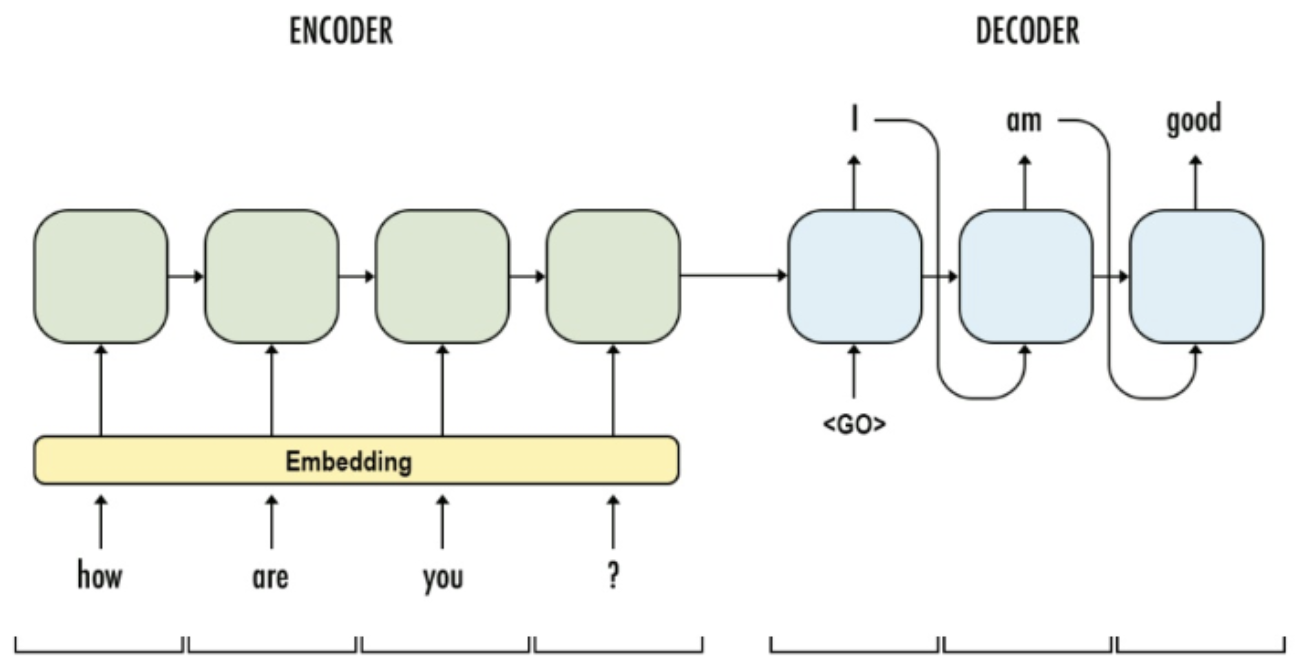

번역기는 인코더와 디코더 두 가지 아키텍처로 구성되어 있다. 

인코더에 입력 문장이 들어가고, 디코더에는 이에 상응하는 출력 문장을 생성한다.

그리고 입력 문장과 출력 문장 두 가지 병렬 구조로 구성된 데이터셋을 훈련한다.

### 훈련 데이터셋의 구성(번역)

- 입렵 문장: '저는 학생입니다.'

- 출력 문장: 'I am a student'

병령적으로 구성된 뎅터셋을 인코더와 디코더로 학습하면 번역기에만 한정되지는 않는다.   
질문에 대해서 대답을 하도록 구성된 데이터셋을 인코더와 디코더 구조로 학습한다면,   
주어진 질문에 답변할 수 이는 챗봇 또한 만들 수 있을 것이다.

### 훈련 데이터셋의 구성(질문-답변)

- 입렵 문장: '오늘의 날씨는 어때?'

- 출력 문장: '오늘은 매우 화창한 날씨야'

### 트랜스포머의 인코더와 디코더

트랜스포머 또한 번역기와 마찬가지로 기본적으로 인코더와 디코더 두성을 가지고 있다.   
입력 문장을 넣으면 출력 문장이 나오게 된다.

![트랜스포머의 인코더와 디코더](http://jalammar.github.io/images/t/the_transformer_3.png)

위의 블랙 박스로 가려져 있는 트랜스포머의 내부 구조를 살펴보면 아래와 같다.

![블랙 박스 내부 구조](http://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)

초록색 색깔의 도형을 인코더 층(Encoder layer), 핑크색 색깔의 도형을 디코더(Decoder layer)이면,   
입력 문장은 누적해 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고,   
디코더는 누적해 쌓아 올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조를 보인다.

![디코더의 하위 계층](http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png)

## 2. 트랜스포머의 입력 이해하기

✅ 필요한 패키지는 아래와 같다.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_4_fuzN6PD.png)

자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거친다.

트랜스포머 또한 다른 모델들과 다르지 않다.

하지만 트랜스포머 모델의 입력 데이터 처리에는 RNN 계열의 모델들과 다른점이 있는데,   
바로 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점이다.

그 값은 위 그림에서의 `포지셔널 인코딩(positional Encoding)` 에 해당한다.

___


위 그림에서 인코더의 입력 부분을 조금 더 확대해보면 아래와 같을 것이다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_5_kH52kQN.png)

이렇게 하는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라,   
문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문이다.

트랜스포머가 RNN과 결정적으로 다른게 이 부분이다.

RNN에는 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없다.   
하지만 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 잘못하면

'I ate lunch' 와 'Lunch ate I' 를 구분을 못할 수 있다.

그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려주기 위해,   
단어의 임베딩 벡터에다가 위치 저보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력값으로 준다.

___

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_6_DyxB6Ax.png)

포지셔널 인코딩의 벡터값은 위의 수식에 의해서 정해진다.

사인 함수와 코사인 함수의 그래프를 보면 요동치는 값의 형태를 생각해 볼 수 있는데,   
트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줘서 단어의 순서 정보를 더해준다.

위의 두 함수에는 pos, i, d model 등 다양한 변수들이 있다.

이 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧엠은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 한다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_7_3Rneu0P.png)

### Question 1.

**한 문장에 같은 단어 A가 여러 번 등장하였다고 가정해보겠습니다. 임베딩 문장 행렬에 포지셔널 인코딩을 해주었을 때와 해주지 않았을 때, 트랜스포머가 임베딩 문장 행렬 내의 다수의 A 단어 벡터로부터 얻을 수 있는 정보의 차이는 어떤 것이 있을?**

> 같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로, 같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있다.

✅ 포지셔널 행렬을 구현해보자.

In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

⏳ 행의 크기가 50, 열의 크기가 512인 행렬을 그려보자.
  - 최대 문장의 길이 50

  - 워드 임베딩 차원 512

  - 모델의 입력 벡터 모양

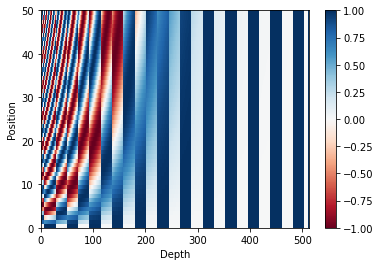

In [4]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Question 2.

**임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30인 텍스트를 입력으로 하는 트랜스포머를 구현한다고 하였을 때, 적절한 포지셔널 인코딩 행렬의 크기를 추측해보고 위에 구현한 포지셔널 인코딩 레이어를 사용해 표현해 보자**

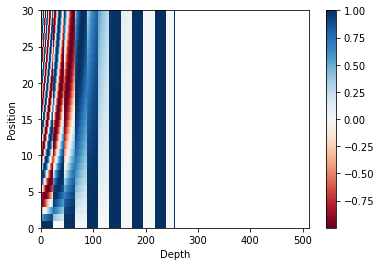

In [5]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

⏳ 실제 논문에서 제시된 그림에서는 다음과 같이 포지셔널 인코딩을 표현하였다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_9_l58gVWT.max-800x600.png)

## 3. 어텐션

✅ 트랜스포머의 인코더와 디코더에서 사용하고 있는 개념인 어텐션에 대해서 알아보자.

### ▶ 어텐션이란❓❓❓
___

어텐션 메커니즘을 그림으로 표현하면 아래의 사진으로 표현할 수 있다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_10_AaCfqrY.png)

1. 어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(key)'와의 유사도를 각각 구한다.   

2. 구해낸 이 유사도를 키(key)와 맵핑되어 있는 각각의 '값(value)'에 반영한다.   

3. 유사도가 반영된 '값(value)'을 모두 더해서 뭉쳐주면 최종 결과인 **어텐션 값(Attention Value)**가 도출된다.

### ▶ 트랜스포머에서 사용된 어텐션
___

트랜스포머는 총 세 가지의 어텐션을 사용한다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_11_tFFhFjx.png)

1. Encoder Self-Attention은 인코데어서 이루어지고

2. Masked Decoder Self-Attention은 디코더에서 이루어지고

3. Encoder-Decoder Attention은 디코더에서 이루어진다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_12_SIe2V15.png)

위 그림은 트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳을 보여준다.

트랜스포머의 어텐션 함수에 사용되는 **쿼리(Query), 키(Key), 밸류(Value)** 는 기본적으로 **'단어(정보를 함축한)벡터' 이다.

단❗, 여기서 **'단어 벡터'**란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 **단어 벡터**이다.

위 세 가지 어텐션이 하는 일을 자세히 알아보자.

1. **Encoder Self-Attention**: 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.

2. **Masked Decoder Self-Attention**: 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.

3. **Encoder-Decoder Attention**: 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

어텐션이 하는 일중 두 가지가 **셀프 어텐션**이다.

❗ 셀프 어텐션이 어떤 의미를 가지고 있으며 트랜스포머에 왜 중요한지 알아보자.

### ▶ 셀프 어텐션(Self Attention)
___

**셀프 어텐션**이란 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말한다.

위에서 언급한 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기에 셀프 어텐션이 아니다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_13_hjMyZwL.png)

위 그림은 [구글 AI 블로그 포스트](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)에서 가져왔다.

위의 예시 문장을 보면 **'그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.'** 라는 의미가 된다.

그런데 여기서 **그것(it)**에 해당하는 것은 과연 **길(street)**인가??? **동물(animal)**인가?

사람은 동물이라는 것을 쉽게 알 수 있지만, 기계는 그렇지 않다.

하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하여 **그것(it)** 이 **동물(animal)** 과 연관되었을 확률이 높다는 것을 찾아낼 수 있다.

## 4. Scaled Dot Product Attention

✅ 앞서 어텐션이 단어들 간의 유사도를 구하는 메커니즘이라고 했다.

그렇다면 유사도를 구하는 방법이 있을 것인데, 트랜스포머에서는 어텐션 값을 구하는 수식은 아래와 같다.

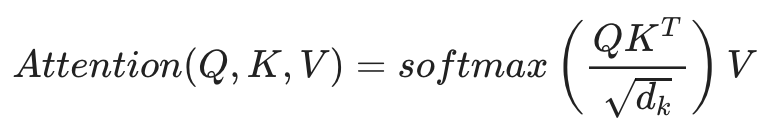

Q, K, V 는 각각 쿼리(Query), 키(Key), 값(Value)를 나타낸다.

- 어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Ke)'와의 **유사도**를 각각 구한다.

- 구해낸 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영한다.

- 유사도가 반영된 '값(Value)'을 모두 더해주면 최종 결과인 **어텐션 값(Attention Value)**이라 한다

❗ 위 정의와 아래 내용 세 가지만 기억하면 수식을 그림으로 정리할 수 있다.

1. **Q, K, V**는 단어 벡터를 행으로 하는 문장 행렬이다.

2. 벡터의 **내적(dot product)** 은 벡터의 **유사도**를 의미한다.

3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.

___


✅ 우선 Q와 K의 전치 행렬을 곱한는 것을 그림으로 표현하면 아래와 같다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_15_pUfIgKn.png)

문장 행렬 Q와 문장 행렬 K를 곱하면 위의 그림과 같은 초록색 행렬을 얻을 수 있다.

**❗ 그럼 초록색 행렬이 의미하는 값은 뭘까????**
> 'am' 행과 'student' 열이 값은 Q행렬에 있던 'am' 벡터와 K 행렬에 있던 'student 벡터'의 내적값을 의미한다.   
결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것이다.

___

**유사도** 값을 스케일링 하기 위해 행렬 전체를 특정 값으로 나눠주고, 유사도르 0 과 1 사이의 값으로 Normalize 해주기 위해서 Softmax 함수를 사용한다.

여기까지가 Q 와 K 의 유사도를 구하는 과정이다.

여기서 문장 행렬 V 와 곱하면 **어텐션 값(Attention Value)**를 얻는다.

이런 것들을 모두 하나의 그림으로 표현하면 아래의 모습과 같다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_16_neA52rZ.png)

아래의 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후,   
특정 값을 분모로 나눠주는 방식으로 Q 와 K의 유사도를 구한 것으로 **Scaled Dot Product Attention)** 이라고 한다.

만약 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 그 어텐션은 **Dot Product Attention**이라고 한다.

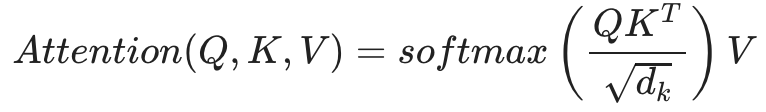

### 코드로 구현해보자
___
✅ Scaled Dot Product Attention 함수를 구현해보자.

In [6]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

## 5. 여러개인 어텐션

### 병렬로 어센션 수행하기
___

✅ 트랜스포머에서 `num_heads` 라는 변수는 기계가 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터이다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_18_nnOTx9p.png)

앞서 포지셔널 인코딩에서 `d_model` 은 임베딩 벡터의 차원이라고 언급한 바 있다.   
결국 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, `d_model` 을 열의 크기로 가진다.

트랜스포머는 이렇게 입력된 문장 행렬을 `num_heads` 의 수만큼 쪼개서 어텐션을 수행하고,   
이렇게 얻은 `num_heads` 의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate 한다.

위의 그림은 num_heads가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 `d_model` 이 된다.



### 멀티-헤드 어텐션
___

✅ 병렬로 어텐션을 수행하면 어떤 효과를 얻을 수 있을까??

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_19_FwmaA3q.png)

위 그림은 `num_heads` 의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 다는 것을 보여주는 그림이다.

8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있다.

예를 들어 위 그림에서라면 `it_` 이라는 토큰이 `animal_` 과 유사하다고 보는 관점과 `street_` 과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻이다.

이와 같이 어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라고 부른다.

### 코드 구현하기
___

✅ **멀티 헤드 어텐션을 구한하면 다음과 같다.   
내부적으로는 **Scaled Dot Product Attention** 함수를 호출한다.

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## 6. 마스킹

✅ **마스킹(Masking)** 이란❓❓❓

특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.

트랜스포머에서는 어텐션을 위해서 크게 두 가지 마스킹을 사용한다.

### 패딩 마스킹(Padding Masking)
___

첫 번째 마스킹은 패딩 토큰(Padding token)을 이용한 방법이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/1365906-20200410103623697-871078599.max-800x600.png)

패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 0을 채워서 문장의 길이를 맞춰주는 자연어 전처리 방법이다.

위 그림은 keras의 `pad_sequences()` 를 사용하여 패딩을 하는 과정을 시각화한 것이다.

이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있다.

**패딩 마스킹**은 이를 위해 숫자 0인 위치를 체크한다.

❗ **패딩 마스킹**을 코드로 구현해보자.

In [8]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

⏳ 이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴한다.

⏳ 두 개의 정수 시퀀스를 입력한 결과는 아래와 같다.

In [9]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


⏳ 두 정수 시퀀스에 대해서 각각 출력되는데, 숫자가 0인 위치에서만 숫자 1이 나오고 숫자가 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다.

### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
___

순환 신경망, RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 완전히 다르다.

RNN은 **step** 이라는 개념이 존재해서 각 **step** 마다 단어가 순서대로 입력으로 들어가며,   
트랜스포머의 경우 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어가는 특징이 있다.


이 특징 때문에 추가적인 **마스킹(Masking)**을 필요로 한다.

**▶ RNN**

RNN으로 다음 단어를 예측하면서 문장을 생성하는 과정을 살펴보자.

아래 그림음 **디코더**를 구현했을 경우이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_20_NAntZnv.max-800x600.png)

RNN은 구조상 다음 단어를 만들어 갈 때, 자신보다 앞에 있는 단어들만 참고해서 다음 단어를 예측한다.

1. **첫 번째 step**
  - 현재까지의 입력: what -> 출력: is

2. **두 번째 step**
  - 현재까지의 입력: what is -> 출력: the

3. **세 번째 step**
  - 현재까지의 입력: what is the -> 출력 problem

**▶ 트랜스포머**

트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측 가능하다.

우리가 원하는 것은 이전 단어들로부터 다음 다어를 예측하는 훈련을 제대로 하는 것이다.

따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 **룩 어헤드 마스킹** 기법이다.

이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 한다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/_.max-800x600.png)

위 그림에서 빨간색으로 색칠된 부분을 마스킹을 표현하고 있다. 

빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이런 단어들하고만 유사도를 구할 수 있다.

❗ 예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 `<s>`, `<나는>`, `<행복을>`, `<찾고>`까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있다.

저 빨간색 부분을 마스킹 함수로 구현하면 아래의 코드와 같다.

In [10]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

직접 입력을 넣어 테스트 해보자.

In [11]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


⏳ 대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있다.

이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 한다.

그래서 `create_look_ahead_mask()` 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출한다.

숫자 0이 포함되었을 경우에도 테스트해 보자.

In [12]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


## 7. 인코더

✅ 트랜스포머의 인코더를 설계해보자.

### 인코더 층 만들기
___

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_21_Y7Cy8sm.max-800x600.png)

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나눠진다.

**셀프 어텐션** 과 **피드 포워드 신경망** 이다.

셀프 어텐션은 **멀티 헤드 어텐션**으로 병렬적으로 이루어진다.

두개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 아래와 같다. 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있다.

In [13]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_22_teJgoCi.max-800x600.png)

### 인코더 층을 쌓아 인코더 만들기
___

구현한 인코더 층을 **임베딩 층(Embedding layer)** 과 **포지셔널 인코딩(Positional Encoding)** 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 **Layer Normalization**이라는 테크닉이 사용되었습니다. 위 그림에서는 **Normalize**라고 표시된 부분에 해당된다.

트랜스포머는 하이퍼파라미터인 **num_layers** 개수의 인코더 층을 쌓는다.

In [14]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 8. 디코더

✅ 디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡하다.

인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다르다.



### 디코더 층
___

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_23_vBHZ3i0.max-800x600.png)

1. 첫 번째는 **셀프 어텐션** 

2. 두 번째는 **인코더-디코더 어텐션**

3. 세 번째는 **피드 포워드 신경망**

**인코더-디코더 어텐션**은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다.

이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_24_Kj9egLY.max-800x600.png)

인코더의 **셀프 어텐션**과 마찬가지로 디코더의 **셀프 어텐션**, **인코더-디코더 어텐션** 두 개의 어텐션 모두 **스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션**으로 병렬적으로 수행한다.

❗ 디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수을 코드로 구현하면 아래와 같다.

In [15]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 디코더 층을 쌓아 디코더 만들기
___

이렇게 구현한 디코더의 층은 **임베딩 층(Embedding layer)** 과 **포지셔널 인코딩(Positional Encoding)** 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

인코더와 마찬가지로 **num_layers** 개수의 디코더 층을 쌓는다.

In [16]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

코더 층과 디코더 층을 각각 함수로 구현하였다.

이를 하나로 조합하여 트랜스포머 모델을 만들 수 있는데,   
그전에 여기서 사용할 챗봇 데이터를 로드하고, 전처리를 하자.

## 9. 챗봇의 병렬 데이터 받아오기

✅ **Cornell Movie-Dialogs Corpus** 라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용할 것이다.

대화의 쌍이라고 하는 것은 기본적으로 먼저 말하는 사람의 대화 문장이 있고, 그에 응답하는 대화 문장의 쌍으로 이루어진다.

1. 정해진 개수인 50,000개의 질문과 답변의 쌍을 추출한다.

2. 문장에서 단어와 구두점 사이에 공백을 추가한다.

3. 알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

In [24]:
import pandas as pd

path_to_dataset = '/content/drive/MyDrive/AIFFEL/data/transformer_chatbot/ChatbotData .csv'

chat_data = pd.read_csv(path_to_dataset)
chat_data.head(20)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [31]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


⏳ 이를 위한 전처리 함수는 다음과 같다.

⏳ 전처리는 **정규 표현식(Regular Expression)** 을 사용하여 **구두점(punctuation)** 을 제거하여 단어를 **토크나이징(tokenizing)** 하는 일에 방해가 되지 않도록 정제하는 것을 목표로 한다.

In [35]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  #- 단어와 구두점(punctuation)사이의 거리 생성
  sentence = re.sub(r"([?.!,])", r" \1", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
  # (ㄱ-ㅎ, ㅏ-ㅣ 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
  # sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip() #- 양쪽 공백 제거
  return sentence

questions = [] #- 질문 리스트
answers = [] #- 답변 리스트


for question in chat_data['Q']:
    
    question = preprocess_sentence(question)
    questions.append(question)
    
    
for answer in chat_data['A']:

    answer = preprocess_sentence(answer)
    answers.append(answer)

#- 전처리가 잘 되었는지 확인
print(questions[:5])
print(answers[:5],'\n')

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .'] 



⏳ 데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리한다.

⏳ 로드한 데이터의 샘플 수를 확인해보자.

In [36]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


⏳ 질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 한다.

⏳ 둘 다 5만 개의 샘플이 저장되었있다.

⏳ 임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인해 보자.

In [37]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


⏳ `?` 나 `.` 과 같은 구두점들이 단어들과 분리되어 단어와 구두점 사이에는 공백이 추가된 것을 확인할 수 있다.

이렇게 함으로써 단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지할 수 있다.

## 10. 병렬 데이터 전처리하기

✅ 질문과 답변의 셋을 각각 **questions**와 **answers**에 저장하였으므로, 전처리를 진행해보자.

1. TensorFlow Datasets **SubwordTextEncoder**를 토크나이저로 사용한다.    
단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 **정수로 인코딩**한다.

2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 `START_TOKEN` 및 `END_TOKEN을` 추가한다.

3. 최대 길이 **MAX_LENGTH**인 40을 넘는 문장들은 필터링한다.

4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 **패딩** 한다.

### 1. 단어장(Vocabulary) 만들기
___

각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보자.  
단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만든다.

In [38]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

⏳ 이때 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여한다. 

⏳ 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 될 것이다.

In [39]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

⏳ 시작 토큰과 종료 토큰에 부여된 정수를 출력해보자.

In [40]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


⏳ 각각 8,331과 8,332라는 점에서 현재 단어장의 크기가 8,331(0번부터 8,330번)이라는 의미이다.

⏳ 두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 한다.

In [41]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
___

위에서 `tensorflow_datasets` 의 `SubwordTextEncoder`를 사용해서 tokenizer를 정의하고 **Vocabulary**를 만들었다면, `tokenizer.encode()` 로 각 단어를 정수로 변환할 수 있고 또는 `tokenizer.decode()` 를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

❗ 2번째 샘플을 `tokenizer.encode()` 의 입력으로 사용해서 변환 결과를 살펴보자.

In [42]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


⏳ 각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있다.

⏳ 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 **정수** 인코딩을 수행한다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 **패딩(padding)** 한다.

In [43]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [44]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

⏳ 정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외된다.

⏳ 단어장의 크기와 샘플의 개수를 확인해 보자.



In [45]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### 3. 교사 강요(Teacher Forcing) 사용하기
___

**tf.data.Dataset API**는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 `tf.data.Dataset` 의 입력으로 넣어주는 작업을 해야한다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 **교사 강요(Teacher Forcing)** 이라는 언어 모델의 훈련 기법을 이해가 필요하다.

- [위키독스: RNN 언어 모델](https://wikidocs.net/46496)

### Question 3.

**교사 강요(Teacher Forcing)를 사용하지 않았을 경우, 훈련 과정에서 훈련 속도가 지나치게 느려지는 경우가 있다고 한다. 그 이유는 무엇인가?**

> 교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.

이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 **자기회귀 모델(auto-regressive model, AR)** 이라고 한다.

앞서 교사 강요를 이해하기 위해 읽었던 글에 등장한 RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델이다.

트랜스포머 디코더에서도 교사 강요(Teacher Forcing) 를 적용한다.

### Question 4.

**만약, answers의 한 샘플이 다음과 같았다고 해보자.**

**샘플 : '<START_TOKEN> I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> <PAD>'**

**<START_TOKEN>은 문장의 시작을 의미하는 시작 토큰, <END_TOKEN>은 문장의 끝을 의미하는 종료 토큰 <PAD>는 패딩을 위해 사용되는 패딩 토큰이다.**

**교사 강요를 적용하기 위해서 위 샘플을 디코더의 입력과 레이블로 사용한다고 하였을 때, 각각 어떻게 수정해서 입력과 레이블로 사용해야 할까?**

> 입력 : `<START_TOKEN>` I AM A STUDENT `<END_TOKEN>` `<PAD>` `<PAD>` `<PAD>`    
레이블 : I AM A STUDENT `<END_TOKEN>` `<PAD>` `<PAD>` `<PAD>` `<PAD>`

⏳ 질문과 답변의 쌍을 **tf.data.Dataset API**의 입력으로 사용하여 파이프라인을 구성한다. 

⏳ 이때, 교사 강요를 위해서 `answers[:, :-1]` 를 디코더의 입력값, `answers[:, 1:]` 를 디코더의 레이블로 사용한다.

In [46]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 11. 모델 정의 및 학습하기

✅ 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의해보자.

In [47]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 1-1. 첫 번째 모델 생성
___

`num_layers`, `d-Model`, `units` 는 전부 사용자가 정할 수 있는 하이퍼파라미터 값이다.

In [48]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3147008     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### 1-2. 두 번째 모델 생성

In [72]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 8 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.001 # 드롭아웃의 비율

model2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model2.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    6309632     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### 2. 손실 함수(Loss function)
___

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [49]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 3. 커스텀 된 학습률(Learning rate)
___

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터이다.

최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다.

이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용한다.

논문에 나온 공식은 아래와 같다.

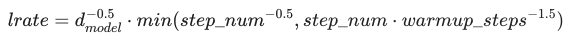

In [50]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

⏳ 그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 보자.

⏳ 위에 언급한 수식은 step_num^(-0.5) 에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있다.

⏳ 그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있다.



Text(0.5, 0, 'Train Step')

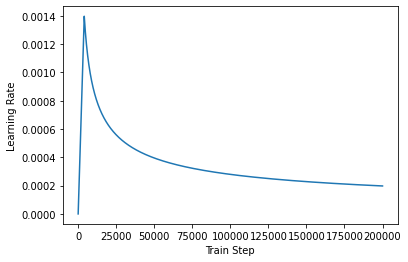

In [51]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4. 모델 컴파일
___

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴일한다.

In [52]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [74]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 5. 훈련하기
___
총 20 에포크를 학습해보자.

### 첫 번째 모델 에폭

In [54]:
EPOCHS = 60
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/60
185/185 [==============================] - 12s 63ms/step - loss: 0.8899 - accuracy: 0.0567
Epoch 2/60
185/185 [==============================] - 11s 57ms/step - loss: 0.8309 - accuracy: 0.0602
Epoch 3/60
185/185 [==============================] - 11s 57ms/step - loss: 0.7672 - accuracy: 0.0655
Epoch 4/60
185/185 [==============================] - 11s 57ms/step - loss: 0.6975 - accuracy: 0.0726
Epoch 5/60
185/185 [==============================] - 11s 57ms/step - loss: 0.6209 - accuracy: 0.0812
Epoch 6/60
185/185 [==============================] - 11s 57ms/step - loss: 0.5387 - accuracy: 0.0905
Epoch 7/60
185/185 [==============================] - 11s 57ms/step - loss: 0.4555 - accuracy: 0.1006
Epoch 8/60
185/185 [==============================] - 11s 57ms/step - loss: 0.3735 - accuracy: 0.1113
Epoch 9/60
185/185 [==============================] - 11s 57ms/step - loss: 0.2967 - accuracy: 0.1221
Epoch 10/60
185/185 [==============================] - 11s 57ms/step - loss: 0.226

### 두 번째 모델 에폭

In [75]:
EPOCHS = 60
history2 = model2.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/60
185/185 [==============================] - 50s 151ms/step - loss: 1.4330 - accuracy: 0.0223
Epoch 2/60
185/185 [==============================] - 28s 151ms/step - loss: 1.1717 - accuracy: 0.0491
Epoch 3/60
185/185 [==============================] - 28s 152ms/step - loss: 1.0075 - accuracy: 0.0499
Epoch 4/60
185/185 [==============================] - 28s 152ms/step - loss: 0.9404 - accuracy: 0.0528
Epoch 5/60
185/185 [==============================] - 28s 151ms/step - loss: 0.9013 - accuracy: 0.0549
Epoch 6/60
185/185 [==============================] - 28s 151ms/step - loss: 0.8654 - accuracy: 0.0568
Epoch 7/60
185/185 [==============================] - 28s 151ms/step - loss: 0.8231 - accuracy: 0.0596
Epoch 8/60
185/185 [==============================] - 28s 151ms/step - loss: 0.7726 - accuracy: 0.0627
Epoch 9/60
185/185 [==============================] - 28s 151ms/step - loss: 0.7168 - accuracy: 0.0671
Epoch 10/60
185/185 [==============================] - 28s 151ms/step - l

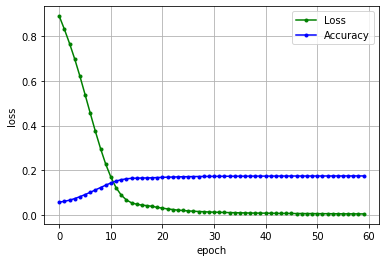

In [59]:
import numpy as np
loss = history.history['loss']
accuracy = history.history['accuracy']

x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='green', label="Loss")
plt.plot(x_len, accuracy, marker='.', c='blue', label="Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

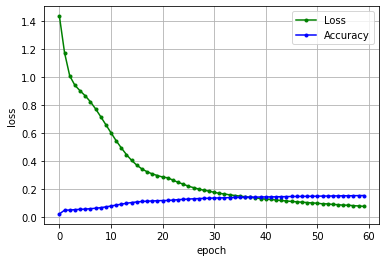

In [77]:
import numpy as np
loss = history2.history['loss']
accuracy = history2.history['accuracy']

x_len = np.arange(len(loss))
plt.plot(x_len, loss, marker='.', c='green', label="Loss")
plt.plot(x_len, accuracy, marker='.', c='blue', label="Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 12. 챗봇 테스트

✅ 예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.

2. 입력 문장을 토크나이징하고, `START_TOKEN`과 `END_TOKEN`을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.

4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.

5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.

6. `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

❗ 위의 과정을 모두 담은 `decoder_inference()` 함수를 만들어보자.

In [55]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [78]:
def decoder_inference2(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model2(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

⏳ 임의의 입력 문장에 대해서 `decoder_inference()` 함수를 호출하여 챗봇의 대답을 얻는 `sentence_generation()` 함수를 만든다.

In [56]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [79]:
def sentence_generation2(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

❗ 임의의 문장으로부터 챗봇의 대답을 얻어보자.

### 결과 1.

In [57]:
sentence_generation('사랑해')

입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

### 결과 2.

In [58]:
sentence_generation("너의 이름은?")

입력 : 너의 이름은?
출력 : 저는 '설레'라고 저장할래요 .


"저는 '설레'라고 저장할래요 ."

In [81]:
sentence_generation2("드라마 재밌어?")

입력 : 드라마 재밌어?
출력 : 저도 드라마 좋아해요 .


'저도 드라마 좋아해요 .'

In [82]:
sentence_generation("집 값이 너무 비싸")

입력 : 집 값이 너무 비싸
출력 : 금연하세요 .


'금연하세요 .'